### Ideas and imports


In [1]:
# Are we allowed to use patient history? If yes there is weird task on multitask classification
# How can it be possible that one person has NO in multiclass within his first visit even though he has more visits...

In [2]:
# Variable for first and secondary visit for patient
# a lot of patients in test are not new so we can build features from their previous data
# work both with pramary secondary and additional diagnosis
# most ppl in dataset have diabetes
# get a list of all diabetes medications
# can try target encoding with discharge disposition
# make a list of all diagnosis and create binary for most popular ones
# try both upsampling and undersampling (add noise)
# encode age differently with center of inteval
# fill missing values better for both test and train
# use more patients we will use later

In [3]:
np.arange(0.3,0.7,0.1)

array([0.3, 0.4, 0.5, 0.6])

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import random
import re
random_state=42
np.random.seed(42)

Columns
- encounter_id - Unique identifier of the encounter
- [x] country - country 
- patient_id - Identifier of the patient
- [x] race - Patient’s race
- [x] gender - Patient’s gender
- [x] age - Patient’s age bracket
- weight - Patient’s weight
- [x] payer_code - Code of the health insurance provider (if there is one)
- [x] outpatient_visits_in_previous_year - Number of outpatient visits (visits made with the intention of leaving on the same day) the patient made to the hospital in the year preceding the encounter
- [x] emergency_visits_in_previous_year - Number of emergency visits the patient made to the hospital in the year preceding the encounter
- [x] inpatient_visits_in_previous_year - Number of inpatient visits (visits with the intention to stay overnight) the patient made to the hospital in the year preceding the encounter
- admission_type - Type of admission of the patient (e.g. Emergency, Urgent,etc…)
- medical_specialty - Medical specialty on which the patient was admitted
- average_pulse_bpm - Average pulse of the patient during their stay in the hospital in beats per minute
- [x] discharge_disposition - Source of the patient before being admitted in the current encounter
- length_of_stay_in_hospital - Number of days between admission and discharge
- number_lab_tests - Number of lab tests performed during the encounter
- non_lab_procedures - Number of non-lab procedures performed during the encounter
- [x] number_of_medications - Number of distinct types of medication administered during the encounter
- primary_diagnosis - Primary diagnosis (coded as first three digits of ICD9)
- secondary_diagnosis - Secondary diagnosis (first three digits of ICD9)
- additional_diagnosis - Additional secondary diagnosis (first three digits of ICD9)
- number_diagnoses - Number of diagnoses entered to the system
- glucose_test_result - Range of the glucose test results or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
- a1c_test_result - Range of the A1C test results or if the test was not taken.Values: “>8” if greater than 8%, “>7” if greater than 7% but less than 8%, “normal” if less than 7%, and “none” if not measured.
- change_in_meds_during_hospitalization - Indicates if there was a change in diabetic medications (dosage or generic name). Values: “change” and “no change”
- prescribed_diabetes_meds - Yes if patient has diabetes medication prescribed. No otherwise.
- medication - List containing all generic names for the medications prescribed to the patient during the encounter. Empty list if no medication was prescribed.
- readmitted_binary - Binary target: Yes if patient was readmitted in less than 30 days, No otherwise.
- readmitted_multiclass - Multiclass target: “<30 days” if the patient was readmitted in less than 30 days after discharge. “>30 days if the patient was readmitted to the hospital but only after more than 30 days after the current discharge. No otherwise.

In [4]:
df_train = pd.read_csv('Data/train.csv')
df_train.head()
#fill missing values with NaN
df_train.replace('?', np.nan, inplace = True)
df_train.replace('Not Mapped', np.nan, inplace = True)
df_train.replace('Not Available', np.nan, inplace = True)
#since we know that NaN is value for no provider let's replace it
df_train['payer_code'].fillna('No provider', inplace = True)

In [5]:
df_test = pd.read_csv('Data/test.csv')
df_test.head()
#fill missing values with NaN
df_test.replace('?', np.nan, inplace = True)
df_test.replace('Not Mapped', np.nan, inplace = True)
#since we know that NaN is value for no provider let's replace it
df_test['payer_code'].fillna('No provider', inplace = True)
df_test

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
0,499502,USA,103232799,Caucasian,Male,[80-90),NaN,HM,0,0,...,14,491,414,250,6,NaN,NaN,No,Yes,['metformin']
1,447319,USA,93395304,Caucasian,Male,[20-30),NaN,HM,0,0,...,7,250.13,70,794,7,>300,NaN,No,No,[]
2,309126,USA,6281586,AfricanAmerican,Male,[30-40),NaN,No provider,0,0,...,12,786,250.6,536,6,NaN,NaN,No,Yes,['insulin']
3,181183,USA,67381308,Caucasian,Male,[50-60),NaN,BC,0,0,...,16,820,873,E884,9,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
4,359339,USA,71670204,Caucasian,Male,[60-70),NaN,No provider,0,0,...,10,599,427,414,9,NaN,NaN,No,Yes,['metformin']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,451150,USA,85707450,Caucasian,Male,[70-80),NaN,HM,0,0,...,11,584,276,276,9,NaN,NaN,No,No,[]
30526,549298,USA,328887,Caucasian,Male,[60-70),NaN,No provider,0,0,...,19,428,250.83,276,9,NaN,NaN,No,Yes,['insulin']
30527,327586,USA,21915459,Caucasian,Female,[80-90),NaN,No provider,0,0,...,22,996,403,250,6,NaN,NaN,No,Yes,['insulin']
30528,351214,USA,17823546,Caucasian,Male,NaN,NaN,MC,0,0,...,21,153,780,285,5,NaN,>7,Ch,Yes,"['glipizide', 'pioglitazone', 'insulin']"


In [33]:
df.groupby('patient_id')['encounter_id'].idxmax()

patient_id
135          29808
378           7333
729          63103
774          48733
927           3174
             ...  
189351095    12488
189365864    47161
189445127    42446
189481478    19117
189502619    23205
Name: encounter_id, Length: 71518, dtype: int64

In [37]:
not_last_visit = df[~df.index.isin(df.groupby('patient_id')['encounter_id'].idxmax())]
not_last_visit[not_last_visit['readmitted_multiclass'] == 'No']

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
26,166876,USA,108031140,Asian,Female,[60-70),NaN,MC,1,0,...,38,403,9,NaN,Norm,Ch,Yes,['glipizide'],No,No
98,103560,USA,27206973,Caucasian,Female,[70-80),NaN,MC,0,0,...,707,428,9,Norm,NaN,Ch,Yes,['insulin'],No,No
121,365029,USA,23852988,Caucasian,Female,[40-50),NaN,MC,3,2,...,250.02,401,6,>200,NaN,Ch,Yes,['insulin'],No,No
128,160434,USA,58121595,Caucasian,Female,[20-30),NaN,PO,1,0,...,648,663,5,NaN,NaN,No,Yes,['metformin'],No,No
210,246757,USA,3356505,Caucasian,Female,[40-50),[125-150),DM,1,0,...,303,493,8,NaN,Norm,No,Yes,['metformin'],No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71157,250468,USA,102225573,Caucasian,Female,[40-50),NaN,HM,0,0,...,250.03,401,9,NaN,NaN,Ch,Yes,['insulin'],No,No
71163,568532,USA,10109502,Caucasian,Female,[70-80),NaN,No provider,0,0,...,428,276,9,NaN,NaN,No,Yes,['insulin'],No,No
71181,527093,USA,1411479,Caucasian,Male,[40-50),NaN,No provider,0,0,...,250.01,296,5,NaN,NaN,No,No,[],No,No
71197,228361,USA,33026733,Caucasian,Male,[80-90),NaN,No provider,1,0,...,261,162,9,NaN,NaN,No,Yes,['insulin'],No,No


In [21]:
df.groupby(by = 'patient_id')['encounter_id'].count().sort_values().tail(50)

patient_id
106526691    13
45305631     13
103140       13
109448541    13
88533495     13
5207247      13
103832127    14
62352252     14
91776843     14
40595031     14
88410879     14
84397842     15
110463471    15
362610       15
16156494     15
85232619     15
86931513     15
34248474     15
2486844      15
41717169     15
84676248     16
90164655     16
384939       16
41617368     16
41699412     17
90489195     17
106757478    17
91160280     18
24011577     18
3481272      18
91751121     18
84348792     18
3401055      18
97391007     19
88681950     19
88479036     19
89472402     20
23398488     20
88789707     20
90609804     20
29903877     20
37096866     20
92709351     21
23643405     22
84428613     22
23199021     23
1660293      23
88227540     23
43140906     28
88785891     40
Name: encounter_id, dtype: int64

In [42]:
df[df['patient_id'] == 23852988].sort_values('encounter_id')

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
121,365029,USA,23852988,Caucasian,Female,[40-50),NaN,MC,3,2,...,250.02,401,6,>200,NaN,Ch,Yes,['insulin'],No,No
59855,835238,USA,23852988,Caucasian,Female,[40-50),NaN,No provider,4,0,...,428,786,8,>300,NaN,Ch,Yes,"['metformin', 'insulin']",No,>30 days
28713,853355,USA,23852988,Caucasian,Female,[40-50),NaN,No provider,6,2,...,496,428,9,Norm,NaN,Ch,Yes,"['metformin', 'insulin']",No,>30 days


In [36]:
df[df['patient_id'] == 108031140].sort_values('encounter_id')

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
26,166876,USA,108031140,Asian,Female,[60-70),NaN,MC,1,0,...,38,403,9,NaN,Norm,Ch,Yes,['glipizide'],No,No
43121,943087,USA,108031140,Asian,Female,[60-70),NaN,MC,1,0,...,428,403,9,NaN,NaN,Ch,Yes,"['glipizide', 'insulin']",No,>30 days


In [17]:
df = pd.concat([df_train, df_test])
df
df[df['patient_id'] == 23492133].sort_values('encounter_id')

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
48618,428048,USA,23492133,AfricanAmerican,Female,[60-70),NaN,MC,0,0,...,707,785,9,NaN,NaN,Ch,Yes,['insulin'],No,No
52473,686437,USA,23492133,AfricanAmerican,Female,[60-70),NaN,MC,0,0,...,440,585,9,NaN,NaN,Ch,Yes,['insulin'],No,>30 days
16,873304,USA,23492133,AfricanAmerican,Female,[60-70),NaN,No provider,0,0,...,403,496,8,NaN,NaN,No,No,[],Yes,<30 days
21005,874040,USA,23492133,AfricanAmerican,Female,[60-70),NaN,No provider,0,0,...,403,682,9,NaN,NaN,No,No,[],No,>30 days


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           71236 non-null  int64 
 1   country                                71236 non-null  object
 2   patient_id                             71236 non-null  int64 
 3   race                                   66166 non-null  object
 4   gender                                 71236 non-null  object
 5   age                                    67679 non-null  object
 6   weight                                 2246 non-null   object
 7   payer_code                             71236 non-null  object
 8   outpatient_visits_in_previous_year     71236 non-null  int64 
 9   emergency_visits_in_previous_year      71236 non-null  int64 
 10  inpatient_visits_in_previous_year      71236 non-null  int64 
 11  admission_type 

In [6]:
#making target variable numerical
df_train['readmitted_binary'] = df_train['readmitted_binary'].replace({'Yes': 1, 'No': 0}).astype(int)
#binary encoding of gender
df_train['gender'] = df_train['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)
#encoding age as label encoding with bigger number if the age is bigger 
df_train['age'] = df_train['age'].replace({'[0-10)': 5,
                                           '[10-20)': 15,
                                           '[20-30)': 25,
                                           '[30-40)': 35,
                                           '[40-50)': 45,
                                           '[50-60)': 55,
                                           '[60-70)': 65,
                                           '[70-80)': 75,
                                           '[80-90)': 85,
                                           '[90-100)': 95})
# df_train['age'] = df_train['age'].replace({'[0-10)': 0,
#                                            '[10-20)': 1,
#                                            '[20-30)': 2,
#                                            '[30-40)': 3,
#                                            '[40-50)': 4,
#                                            '[50-60)': 5,
#                                            '[60-70)': 6,
#                                            '[70-80)': 7,
#                                            '[80-90)': 8,
#                                            '[90-100)': 9})
#all patients are from USA so country is irrelevant feature
df_train.drop(columns = ['country'], inplace = True)
#less than 5% of observation has weight measure
#so, we'll just create  binary variable indicating observation has weight value or not
df_train['has_weight'] = df_train['weight'].apply(lambda x: 0 if pd.isna(x) else 1)

df_train.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass,has_weight
0,533253,70110,Caucasian,1.0,75.0,NaN,No provider,0,0,2,...,466,8,NaN,NaN,No,No,[],0,>30 days,0
1,426224,29775006,AfricanAmerican,0.0,55.0,NaN,No provider,0,0,0,...,162,9,NaN,NaN,No,Yes,['insulin'],0,No,0
2,634063,80729253,Caucasian,1.0,65.0,NaN,No provider,0,0,1,...,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",0,No,0
3,890610,2919042,AfricanAmerican,0.0,65.0,NaN,MC,0,0,1,...,455,5,NaN,NaN,No,No,[],0,No,0
4,654194,84871971,Caucasian,1.0,75.0,NaN,HM,1,0,0,...,428,9,NaN,NaN,No,No,[],0,>30 days,0


In [7]:
#binary encoding of gender
df_test['gender'] = df_test['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)
#encoding age as label encoding with bigger number if the age is bigger
df_test['age'] = df_test['age'].replace({'[0-10)': 5,
                                           '[10-20)': 15,
                                           '[20-30)': 25,
                                           '[30-40)': 35,
                                           '[40-50)': 45,
                                           '[50-60)': 55,
                                           '[60-70)': 65,
                                           '[70-80)': 75,
                                           '[80-90)': 85,
                                           '[90-100)': 95})
# df_test['age'] = df_test['age'].replace({'[0-10)': 0,
#                                            '[10-20)': 1,
#                                            '[20-30)': 2,
#                                            '[30-40)': 3,
#                                            '[40-50)': 4,
#                                            '[50-60)': 5,
#                                            '[60-70)': 6,
#                                            '[70-80)': 7,
#                                            '[80-90)': 8,
#                                            '[90-100)': 9})
#all patients are from USA so country is irrelevant feature
df_test.drop(columns = ['country'], inplace = True)
#less than 5% of observation has weight measure
#so, we'll just create binary variable indicating observation has weight value or not
df_test['has_weight'] = df_test['weight'].apply(lambda x: 0 if pd.isna(x) else 1)

df_test


,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,has_weight
0,499502,103232799,Caucasian,0.0,85.0,NaN,HM,0,0,0,...,491,414,250,6,NaN,NaN,No,Yes,['metformin'],0
1,447319,93395304,Caucasian,0.0,25.0,NaN,HM,0,0,1,...,250.13,70,794,7,>300,NaN,No,No,[],0
2,309126,6281586,AfricanAmerican,0.0,35.0,NaN,No provider,0,0,0,...,786,250.6,536,6,NaN,NaN,No,Yes,['insulin'],0
3,181183,67381308,Caucasian,0.0,55.0,NaN,BC,0,0,0,...,820,873,E884,9,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']",0
4,359339,71670204,Caucasian,0.0,65.0,NaN,No provider,0,0,0,...,599,427,414,9,NaN,NaN,No,Yes,['metformin'],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,451150,85707450,Caucasian,0.0,75.0,NaN,HM,0,0,0,...,584,276,276,9,NaN,NaN,No,No,[],0
30526,549298,328887,Caucasian,0.0,65.0,NaN,No provider,0,0,4,...,428,250.83,276,9,NaN,NaN,No,Yes,['insulin'],0
30527,327586,21915459,Caucasian,1.0,85.0,NaN,No provider,0,0,0,...,996,403,250,6,NaN,NaN,No,Yes,['insulin'],0
30528,351214,17823546,Caucasian,0.0,NaN,NaN,MC,0,0,0,...,153,780,285,5,NaN,>7,Ch,Yes,"['glipizide', 'pioglitazone', 'insulin']",0


In [8]:
#Let's consider only most popular providers (>1% of dataset) and group all others to another group
cnt = df_train[['payer_code', 'encounter_id']].groupby(by = 'payer_code').count().sort_values(by='encounter_id', ascending = False)
share = cnt/df_train['payer_code'].count()
big_share = share > 0.01
big_share_providers = list(big_share[big_share['encounter_id'] == True].index)
df_train['payer_code'] = df_train['payer_code'].apply(lambda x: x if x in big_share_providers else 'Other provider')
#one hot encoding for this variable since it has no order
#use drop='first' to avoid multicollinearity
encoder_payer_code = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_payer_code.fit_transform(df_train['payer_code'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis=1)
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'payer_code_CM', 'payer_code_CP', 'payer_code_HM',
       'payer_code_MC', 'payer_code_MD', 'payer_code_No provider',
       'payer_code_OG', 'payer_code_Other provider', 'payer_code_SP',
       'payer_code_UN'],
      dtype='object')

In [9]:
#Do the same thing for test, but only use providers from train dataset - put other to group Other provider
df_test['payer_code'] = df_test['payer_code'].apply(lambda x: x if x in big_share_providers else 'Other provider')
one_hot_encoded = encoder_payer_code.transform(df_test['payer_code'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis=1)
df_test

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,payer_code_CM,payer_code_CP,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_No provider,payer_code_OG,payer_code_Other provider,payer_code_SP,payer_code_UN
0,499502,103232799,Caucasian,0.0,85.0,NaN,HM,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,447319,93395304,Caucasian,0.0,25.0,NaN,HM,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,309126,6281586,AfricanAmerican,0.0,35.0,NaN,No provider,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,181183,67381308,Caucasian,0.0,55.0,NaN,BC,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,359339,71670204,Caucasian,0.0,65.0,NaN,No provider,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,451150,85707450,Caucasian,0.0,75.0,NaN,HM,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30526,549298,328887,Caucasian,0.0,65.0,NaN,No provider,0,0,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30527,327586,21915459,Caucasian,1.0,85.0,NaN,No provider,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30528,351214,17823546,Caucasian,0.0,NaN,NaN,MC,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Let's do one hot encoding for race variable 
#Let's keep NaN as extra column since we don't know the exact reason why is it empty and might need it later
encoder_race = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_race.fit_transform(df_train['race'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_race.get_feature_names_out(['race']))], axis=1)
#drop original column since we don't need it anymore for model training
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'payer_code_CM', 'payer_code_CP', 'payer_code_HM',
       'payer_code_MC', 'payer_code_MD', 'payer_code_No provider',
       'payer_code_OG', 'payer_code_Other provider', 'payer_code_SP',
       'payer_code_UN', 'race_Asian', 'race_Caucasian', 'race_

In [11]:
one_hot_encoded_test = encoder_race.transform(df_test['race'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded_test, columns=encoder_race.get_feature_names_out(['race']))], axis=1)
#drop original column since we don't need it anymore for model training
df_test.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,payer_code_No provider,payer_code_OG,payer_code_Other provider,payer_code_SP,payer_code_UN,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_nan
0,499502,103232799,Caucasian,0.0,85.0,NaN,HM,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,447319,93395304,Caucasian,0.0,25.0,NaN,HM,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,309126,6281586,AfricanAmerican,0.0,35.0,NaN,No provider,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,181183,67381308,Caucasian,0.0,55.0,NaN,BC,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,359339,71670204,Caucasian,0.0,65.0,NaN,No provider,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


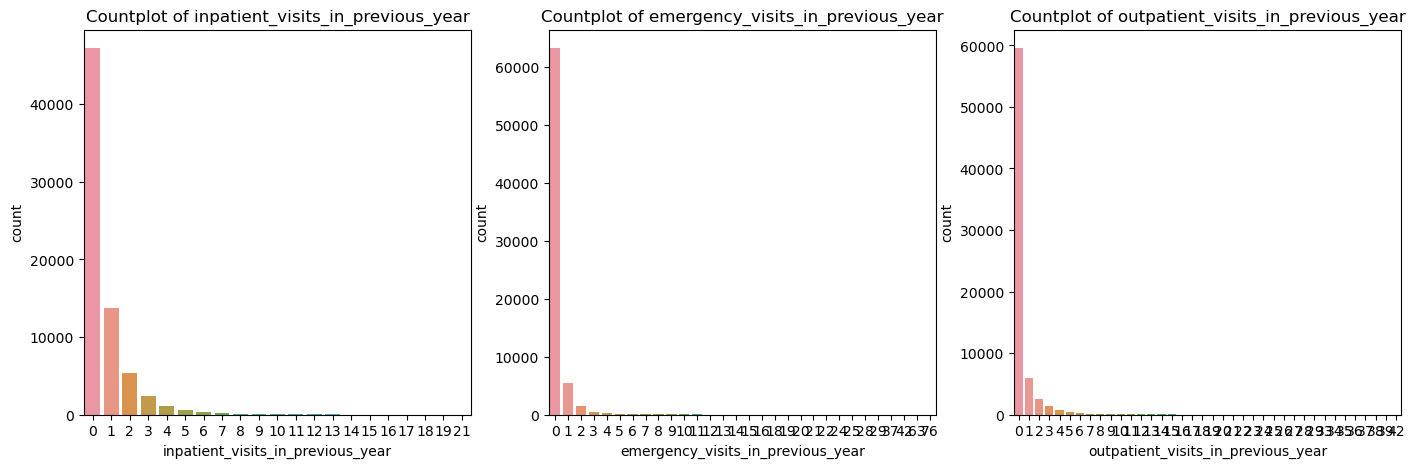

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.countplot(x='inpatient_visits_in_previous_year', data=df_train, ax=axes[0])
sns.countplot(x='emergency_visits_in_previous_year', data=df_train, ax=axes[1])
sns.countplot(x='outpatient_visits_in_previous_year', data=df_train, ax=axes[2])
axes[0].set_title("Countplot of inpatient_visits_in_previous_year")
axes[1].set_title("Countplot of emergency_visits_in_previous_year")
axes[2].set_title("Countplot of outpatient_visits_in_previous_year")
plt.show()

In [13]:
#adding variables of total number of visits and max of any type
df_train['total_visits'] = df_train['outpatient_visits_in_previous_year'] + df_train['emergency_visits_in_previous_year'] + df_train['inpatient_visits_in_previous_year']
df_test['total_visits'] = df_test['outpatient_visits_in_previous_year'] + df_test['emergency_visits_in_previous_year'] + df_test['inpatient_visits_in_previous_year']

df_train['max_visits_of_one_type'] = df_train[['outpatient_visits_in_previous_year',
          'emergency_visits_in_previous_year',
          'inpatient_visits_in_previous_year']].max(axis = 1)
df_test['max_visits_of_one_type'] = df_test[['outpatient_visits_in_previous_year',
          'emergency_visits_in_previous_year',
          'inpatient_visits_in_previous_year']].max(axis = 1)

<Axes: >

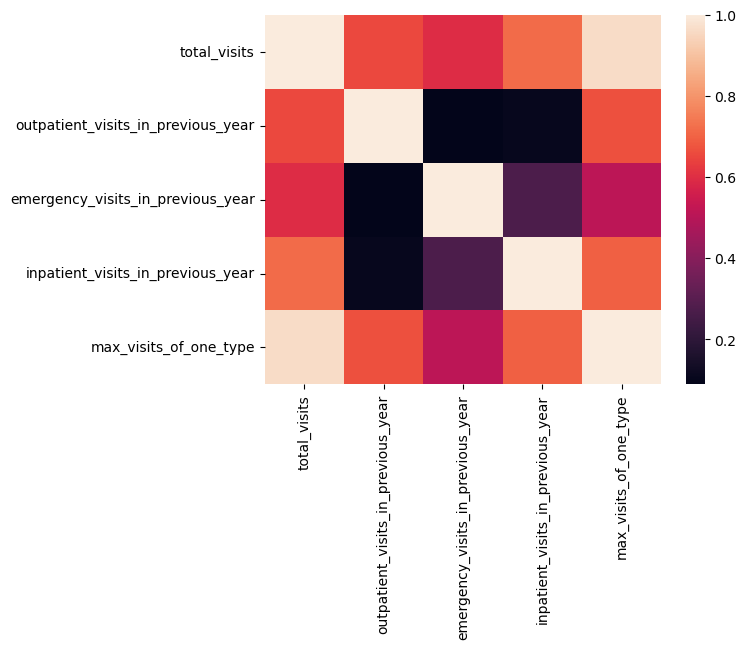

In [14]:
sns.heatmap(df_train[['total_visits',
                      'outpatient_visits_in_previous_year',
                     'emergency_visits_in_previous_year',
                     'inpatient_visits_in_previous_year',
                     'max_visits_of_one_type']].corr())

In [15]:
# since more than 5 visits in each category is very rare but may be important indicator 
# we will cut distributions to 5 
df_train['total_visits'] = df_train['total_visits'].apply(lambda x: 5 if x>5 else x)
df_train['max_visits_of_one_type'] = df_train['max_visits_of_one_type'].apply(lambda x: 5 if x>5 else x)
df_train['outpatient_visits_in_previous_year'] = df_train['outpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_train['emergency_visits_in_previous_year'] = df_train['emergency_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_train['inpatient_visits_in_previous_year'] = df_train['inpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)

In [16]:
# since more than 5 visits in each category is very rare but may be important indicator 
# we will cut distributions to 5 for these 3 variables
# and 4th variable for total visits
df_test['total_visits'] = df_test['total_visits'].apply(lambda x: 5 if x>5 else x)
df_test['max_visits_of_one_type'] = df_test['max_visits_of_one_type'].apply(lambda x: 5 if x>5 else x)

df_test['outpatient_visits_in_previous_year'] = df_test['outpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_test['emergency_visits_in_previous_year'] = df_test['emergency_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_test['inpatient_visits_in_previous_year'] = df_test['inpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)

In [17]:
cnt = df_train[['admission_type', 'encounter_id']].groupby(by = 'admission_type').count().sort_values(by='encounter_id', ascending = False)
share = cnt/df_train['admission_type'].count()
big_share = share > 0.01
big_share_admissions = list(big_share[big_share['encounter_id'] == True].index)
df_train['admission_type'] = df_train['admission_type'].apply(lambda x: x if x in big_share_admissions else ('nan' if pd.isna(x) else 'Other type' ))
#one hot encoding for this variable since it has no order
#use drop='first' to avoid multicollinearity
encoder_admission_type = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_admission_type.fit_transform(df_train['admission_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_admission_type.get_feature_names_out(['admission_type']))], axis=1)
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'payer_code_CM', 'payer_code_CP', 'payer_code_HM',
       'payer_code_MC', 'payer_code_MD', 'payer_code_No provider',
       'payer_code_OG', 'payer_code_Other provider', 'payer_code_SP',
       'payer_code_UN', 'race_Asian', 'race_Caucasian', 'race_

In [18]:
#Do the same thing for test, but only use providers from train dataset - put other to group Other provider
df_test['admission_type'] = df_test['admission_type'].apply(lambda x: x if x in big_share_admissions else ('nan' if pd.isna(x) else 'Other type' ))
one_hot_encoded = encoder_admission_type.transform(df_test['admission_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_admission_type.get_feature_names_out(['admission_type']))], axis=1)
df_test.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'has_weight', 'payer_code_CM', 'payer_code_CP',
       'payer_code_HM', 'payer_code_MC', 'payer_code_MD',
       'payer_code_No provider', 'payer_code_OG', 'payer_code_Other provider',
       'payer_code_SP', 'payer_code_UN', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'race_nan', 'total_vi

In [19]:
# lets check for most popular categories that have most connection with target and do binary for them
# create variable is_expired since cannot come again
# rehab is important - higher chance of coming again
# going home or hospice is important - lower chance of coming again 
# another instition is important - higher chance of coming again
# psychiatric is important - higher chance of coming again
cnt = df_train[['encounter_id','discharge_disposition']].groupby(by = 'discharge_disposition').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','discharge_disposition']].groupby(by = 'discharge_disposition').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1)

,encounter_id,readmitted_binary
discharge_disposition,,
Discharged to home,42256,0.092744
Discharged/transferred to SNF,9780,0.146217
Discharged/transferred to home with home health service,9005,0.126374
Discharged/transferred to another short term hospital,1488,0.165323
Discharged/transferred to another rehab fac including rehab units of a hospital .,1393,0.278536
Expired,1135,0.000000
Discharged/transferred to another type of inpatient care institution,822,0.209246
Discharged/transferred to ICF,571,0.124343
Left AMA,421,0.147268


In [20]:
df_train['discharged_home_hospice'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                              1 if (x == 'Discharged to home'
                                                                                   or x == 'Hospice / medical facility'
                                                                                   or x == 'Hospice / home')
                                                                              else 0)
df_train['expired'] = df_train['discharge_disposition'].apply(lambda x: 1 if x == 'Expired' else 0)
df_train['transferred_rehub'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                        1 if x == 'Discharged/transferred to another rehab fac including rehab units of a hospital' else 0)
df_train['transferred_another_institution'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another type of inpatient care institution' else 0)
df_train['transferred_psychiatric_hospital'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital	' else 0)


In [21]:
df_test['discharged_home_hospice'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                              1 if (x == 'Discharged to home'
                                                                                   or x == 'Hospice / medical facility'
                                                                                   or x == 'Hospice / home')
                                                                              else 0)
df_test['expired'] = df_test['discharge_disposition'].apply(lambda x: 1 if x == 'Expired' else 0)
df_test['transferred_rehub'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                        1 if x == 'Discharged/transferred to another rehab fac including rehab units of a hospital' else 0)
df_test['transferred_another_institution'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another type of inpatient care institution' else 0)
df_test['transferred_psychiatric_hospital'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital	' else 0)


In [22]:
#binary idetifier if there was medication or not
df_train['medication_binary'] = df_train['medication'].apply(lambda x: 0 if x == '[]' else (1 if len(str(x)) > 2 else np.nan))

df_test['medication_binary'] = df_test['medication'].apply(lambda x: 0 if x == '[]' else (1 if len(str(x)) > 2 else np.nan))

In [23]:
medication_list = []
for i in df_train['medication']:
    i = i.replace('[', '').replace(']', '').replace("'", '').replace('-', ',')
    x = i.strip().split(',')
    for j in x:
        if len(j) > 0:
            medication_list.append(j.strip())
medication_list = list(set(medication_list))
medication_list

['rosiglitazone',
 'glimepiride',
 'repaglinide',
 'miglitol',
 'chlorpropamide',
 'nateglinide',
 'pioglitazone',
 'glyburide',
 'acetohexamide',
 'tolbutamide',
 'troglitazone',
 'acarbose',
 'tolazamide',
 'insulin',
 'metformin',
 'glipizide']

In [24]:
for i in medication_list:
    df_train[i] = df_train['medication'].astype(str).apply(lambda x: 1 if i in x else 0)
    df_test[i] = df_test['medication'].astype(str).apply(lambda x: 1 if i in x else 0)
#get rid of rare medications columns
for i in medication_list:
    if df_train[i].sum()/len(df_train) < 0.01:
        df_train.drop(columns = [i], inplace = True)
        df_test.drop(columns = [i], inplace = True)

In [25]:
for i in medication_list:
    try:
        cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
        mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
        print(pd.concat([cnt, mean], axis = 1))
    except:
        pass

               encounter_id  readmitted_binary
rosiglitazone                                 
0                     66762           0.112025
1                      4474           0.105275
             encounter_id  readmitted_binary
glimepiride                                 
0                   67661           0.112310
1                    3575           0.098182
             encounter_id  readmitted_binary
repaglinide                                 
0                   70158           0.111192
1                    1078           0.138219
              encounter_id  readmitted_binary
pioglitazone                                 
0                    66143           0.111909
1                     5093           0.107599
           encounter_id  readmitted_binary
glyburide                                 
0                 63251           0.112314
1                  7985           0.105949
         encounter_id  readmitted_binary
insulin                                 
1             

In [26]:
cnt = df_train[['encounter_id','medication_binary']].groupby(by = 'medication_binary').count().sort_values(by = 'encounter_id', ascending=False).head(50)
mean = df_train[['readmitted_binary','medication_binary']].groupby(by = 'medication_binary').mean().sort_values(by = 'readmitted_binary', ascending=False).head(50)
pd.concat([cnt, mean], axis = 1)

,encounter_id,readmitted_binary
medication_binary,,
1,54890,0.116305
0,16346,0.095803


From what i found we can try to sort diabetes types by severity and make some order to create new variable

To make it more simple let's consider only 4 digits of code for this task. Here is the order from less severe to most severe according to what i found:

1. Non-specific code 250 Diabetes mellitus
2. Non-specific code 250.0 Diabetes mellitus without mention of complication
3. Non-specific code 250.9 Diabetes with unspecified complication
4. Non-specific code 250.8 Diabetes with other specified manifestations
5. Non-specific code 250.7 Diabetes with peripheral circulatory disorders
6. Non-specific code 250.6 Diabetes with neurological manifestations
7. Non-specific code 250.5 Diabetes with ophthalmic manifestations
8. Non-specific code 250.4 Diabetes with renal manifestations
9. Non-specific code 250.3 Diabetes with other coma
10. Non-specific code 250.2 Diabetes with hyperosmolarity
11. Non-specific code 250.1 Diabetes with ketoacidosis

And one more variable with types of diabetes (1/2, controlled/uncontrolled, dont know):

- ***.*0 type II or unspecified type, not stated as uncontrolled - in our case i guess it will be just ***.*
- ***.*1 type I [juvenile type], not stated as uncontrolled 
- ***.*2 type II or unspecified type, uncontrolled 
- ***.*3 type I [juvenile type], uncontrolled

In [27]:
d = pd.concat([df_train['primary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_train['secondary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_train['additional_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan)], axis = 1)
d.fillna('q', inplace = True)
df_train['diabetes_diagnosis'] = (d['secondary_diagnosis']+d['primary_diagnosis']+d['additional_diagnosis']).apply(lambda x: x.replace('q', ''))

d = pd.concat([df_test['primary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_test['secondary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_test['additional_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan)], axis = 1)
d.fillna('q', inplace = True)
df_test['diabetes_diagnosis'] = (d['secondary_diagnosis']+d['primary_diagnosis']+d['additional_diagnosis']).apply(lambda x: x.replace('q', ''))

In [28]:
df_train['diabetes_diagnosis_4_digits'] = df_train['diabetes_diagnosis'].astype(str).apply(lambda x: x[:5].replace('25025', '250'))
df_test['diabetes_diagnosis_4_digits'] = df_test['diabetes_diagnosis'].astype(str).apply(lambda x: x[:5].replace('25025', '250'))

df_train['diabetes_type'] = df_train['diabetes_diagnosis'].apply(lambda x: 'I - uncontrolled' 
                                     if re.match(r'\d{3}\.\d{1}3', x)        
                                     else ( 'II - uncontrolled'
                                           if re.match(r'\d{3}\.\d{1}2', x)
                                     else ( 'I - controlled'
                                           if re.match(r'\d{3}\.\d{1}1', x)
                                     else ( 'II - controlled'
                                           if re.match(r'\d{3}\.', x)
                                     else np.nan))))
df_test['diabetes_type'] = df_test['diabetes_diagnosis'].apply(lambda x: 'I - uncontrolled' 
                                     if re.match(r'\d{3}\.\d{1}3', x) 
                                     
                                     else ( 'II - uncontrolled'
                                           if re.match(r'\d{3}\.\d{1}2', x)
                                     else ( 'I - controlled'
                                           if re.match(r'\d{3}\.\d{1}1', x)
                                     else ( 'II - controlled'
                                           if re.match(r'\d{3}\.', x)
                                     else np.nan))))

In [29]:
i = 'diabetes_diagnosis_4_digits'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_diagnosis_4_digits,,
250.9,341,0.117302
250.8,2333,0.135448
250.7,752,0.196809
250.6,2019,0.174344
250.5,308,0.159091
250.4,1208,0.156457
250.3,56,0.125000
250.2,255,0.058824
250.1,1756,0.124146


In [30]:
#one hot encoding for this variable since it has no order
#use drop='first' to avoid multicollinearity
encoder_diabetes_type = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_diabetes_type.fit_transform(df_train['diabetes_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_type.get_feature_names_out(['diabetes_type']))], axis=1)
df_train.columns

#Do the same thing for test, but only use providers from train dataset 
one_hot_encoded = encoder_diabetes_type.transform(df_test['diabetes_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_type.get_feature_names_out(['diabetes_type']))], axis=1)
df_test.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'has_weight', 'payer_code_CM', 'payer_code_CP',
       'payer_code_HM', 'payer_code_MC', 'payer_code_MD',
       'payer_code_No provider', 'payer_code_OG', 'payer_code_Other provider',
       'payer_code_SP', 'payer_code_UN', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'race_nan', 'total_vi

In [31]:
#one hot encoding for this variable since it has no order
#use drop='first' to avoid multicollinearity
encoder_diabetes_diagnosis_4_digits = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_diabetes_diagnosis_4_digits.fit_transform(df_train['diabetes_diagnosis_4_digits'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_diagnosis_4_digits.get_feature_names_out(['diabetes_diagnosis_4_digits']))], axis=1)
df_train.columns

#Do the same thing for test, but only use providers from train dataset 
one_hot_encoded = encoder_diabetes_diagnosis_4_digits.transform(df_test['diabetes_diagnosis_4_digits'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_diagnosis_4_digits.get_feature_names_out(['diabetes_diagnosis_4_digits']))], axis=1)
df_test.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'has_weight', 'payer_code_CM', 'payer_code_CP',
       'payer_code_HM', 'payer_code_MC', 'payer_code_MD',
       'payer_code_No provider', 'payer_code_OG', 'payer_code_Other provider',
       'payer_code_SP', 'payer_code_UN', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'race_nan', 'total_vi

In [32]:
df_train['change_in_meds_during_hospitalization'] = df_train['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0}).astype(int)
df_test['change_in_meds_during_hospitalization'] = df_test['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0}).astype(int)

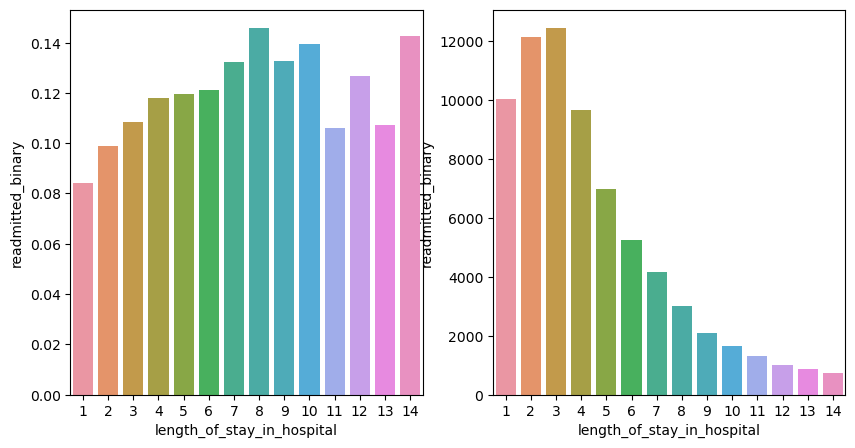

In [33]:
i = 'length_of_stay_in_hospital'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['readmitted_binary'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='readmitted_binary', data=counts, ax=axes[1])

# Set labels for the x and y axes
# plt.xlabel(i)
# plt.ylabel('Average Readmitted')

# Show the barplot
plt.show()

<Axes: xlabel='bin_length_of_stay_in_hospital', ylabel='readmitted_binary'>

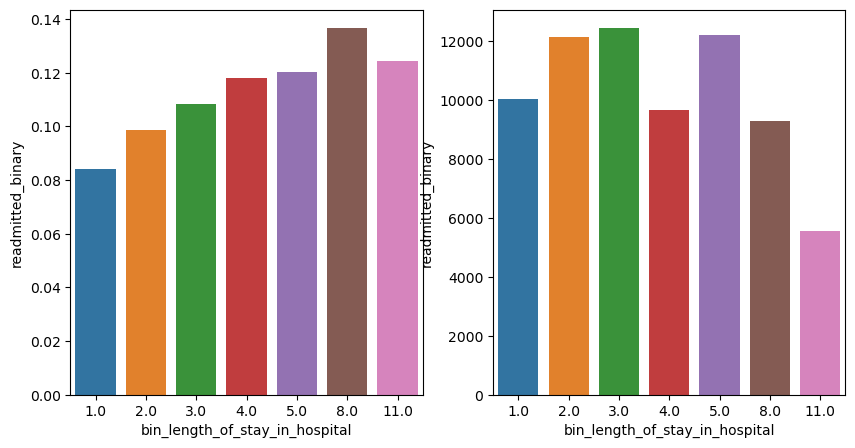

In [34]:
bin_edges = [0, 1, 2, 3, 4, 6, 9, 14]  # bin edges to make categories more equal
#labels will be medians of each category
bin_labels = [np.median(df_train[(df_train['length_of_stay_in_hospital'] > bin_edges[i]) &
                     (df_train['length_of_stay_in_hospital'] <= bin_edges[i+1])    
                                      ]['length_of_stay_in_hospital'])  for i in range(len(bin_edges)-1)] 
df_train['bin_length_of_stay_in_hospital'] = pd.cut(df_train['length_of_stay_in_hospital'], bins=bin_edges, labels=bin_labels)
df_test['bin_length_of_stay_in_hospital'] = pd.cut(df_test['length_of_stay_in_hospital'], bins=bin_edges, labels=bin_labels) 

i = 'bin_length_of_stay_in_hospital'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['readmitted_binary'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='readmitted_binary', data=counts, ax=axes[1])

In [35]:
#doing the same thing for number of medications

bin_edges = np.percentile(df_train['number_of_medications'], np.linspace(0, 100, 11))
bin_edges[0] = bin_edges[0] - 1
bin_edges[-1] = 100
bin_labels = [np.median(df_train[(df_train['number_of_medications'] > bin_edges[i]) &
                     (df_train['number_of_medications'] <= bin_edges[i+1])    
                                      ]['number_of_medications'])  for i in range(len(bin_edges)-1)] 

# Create a new 'bins' column based on the 'number_of_medications' column
df_train['bin_number_of_medications'] = pd.cut(df_train['number_of_medications'], bins=bin_edges, labels=bin_labels)
df_test['bin_number_of_medications'] = pd.cut(df_test['number_of_medications'], bins=bin_edges, labels=bin_labels)

<Axes: xlabel='bin_number_of_medications', ylabel='readmitted_binary'>

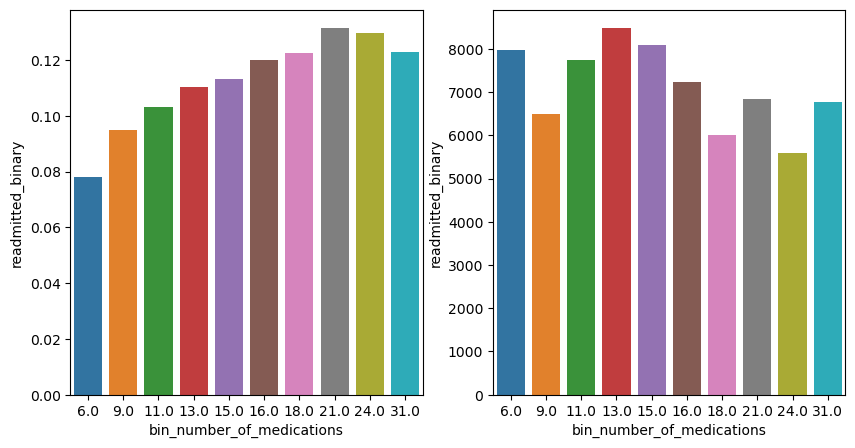

In [36]:
i = 'bin_number_of_medications'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['readmitted_binary'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='readmitted_binary', data=counts, ax=axes[1])

In [37]:
#creating 3 variables: visited before, num_visits_before, readmitted_before
#can also create readmitted previous visit
same_patient = pd.merge(df_train, df_train, on='patient_id', how='inner')
prev_visit = same_patient[same_patient['encounter_id_x'] > same_patient['encounter_id_y']][['encounter_id_x', 'encounter_id_y', 'readmitted_binary_y', 'patient_id']]
readmitted_before = prev_visit[['encounter_id_x', 'readmitted_binary_y']].drop_duplicates().groupby(by = ['encounter_id_x']).max().reset_index()
num_visits_before = prev_visit[['encounter_id_x', 'encounter_id_y']].drop_duplicates().groupby(by = ['encounter_id_x']).count().reset_index()
df_visits = pd.merge(num_visits_before, readmitted_before, on = 'encounter_id_x').rename(columns = {'encounter_id_x' : 'encounter_id',
                                                                                    'encounter_id_y': 'num_visits_before',
                                                                                    'readmitted_binary_y': 'readmitted_before'
                                                                                    })
df_train = pd.merge(df_train, df_visits, on = 'encounter_id', how = 'left')
df_train['num_visits_before'].fillna(0, inplace = True)
df_train['readmitted_before'].fillna(0, inplace = True)
df_train['visited_before'] = df_train['num_visits_before'].apply(lambda x: 1 if x > 0 else 0)

In [38]:
same_patient = pd.merge(df_test, pd.concat([df_train, df_test], axis = 0), on='patient_id', how='inner')
prev_visit = same_patient[same_patient['encounter_id_x'] > same_patient['encounter_id_y']][['encounter_id_x', 'encounter_id_y', 'readmitted_binary', 'patient_id']]
readmitted_before = prev_visit[['encounter_id_x', 'readmitted_binary']].drop_duplicates().groupby(by = ['encounter_id_x']).max().reset_index()
num_visits_before = prev_visit[['encounter_id_x', 'encounter_id_y']].drop_duplicates().groupby(by = ['encounter_id_x']).count().reset_index()
df_visits = pd.merge(num_visits_before, readmitted_before, on = 'encounter_id_x').rename(columns = {'encounter_id_x' : 'encounter_id',
                                                                                    'encounter_id_y': 'num_visits_before',
                                                                                    'readmitted_binary': 'readmitted_before'
                                                                                    })
df_test = pd.merge(df_test, df_visits, on = 'encounter_id', how = 'left')
df_test['num_visits_before'].fillna(0, inplace = True)
df_test['readmitted_before'].fillna(0, inplace = True)
df_test['visited_before'] = df_test['num_visits_before'].apply(lambda x: 1 if x > 0 else 0)
df_test.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,diabetes_diagnosis_4_digits_250.5,diabetes_diagnosis_4_digits_250.6,diabetes_diagnosis_4_digits_250.7,diabetes_diagnosis_4_digits_250.8,diabetes_diagnosis_4_digits_250.9,bin_length_of_stay_in_hospital,bin_number_of_medications,num_visits_before,readmitted_before,visited_before
0,499502,103232799,Caucasian,0.0,85.0,NaN,HM,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,15.0,1.0,0.0,1
1,447319,93395304,Caucasian,0.0,25.0,NaN,HM,0,0,1,...,0.0,0.0,0.0,0.0,0.0,11.0,6.0,1.0,0.0,1
2,309126,6281586,AfricanAmerican,0.0,35.0,NaN,No provider,0,0,0,...,0.0,1.0,0.0,0.0,0.0,2.0,13.0,0.0,0.0,0
3,181183,67381308,Caucasian,0.0,55.0,NaN,BC,0,0,0,...,0.0,0.0,0.0,0.0,0.0,4.0,16.0,0.0,0.0,0
4,359339,71670204,Caucasian,0.0,65.0,NaN,No provider,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0


In [39]:
from sklearn.impute import KNNImputer

df_train_for_transform = df_train[[
       'gender', 
       'age', 
       'has_weight',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'number_of_medications',                                     
       'bin_number_of_medications',             
       'discharged_home_hospice',
       'expired', 
       'transferred_rehub', 
       'transferred_another_institution',
       'transferred_psychiatric_hospital', 
       'length_of_stay_in_hospital',
       'change_in_meds_during_hospitalization',
       'bin_number_of_medications',
       'bin_length_of_stay_in_hospital',
       'total_visits',
       'max_visits_of_one_type'
]]
df_test_for_transform = df_test[[
       'gender', 
       'age', 
       'has_weight',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'number_of_medications',                                     
       'bin_number_of_medications',             
       'discharged_home_hospice',
       'expired', 
       'transferred_rehub', 
       'transferred_another_institution',
       'transferred_psychiatric_hospital', 
       'length_of_stay_in_hospital',
       'change_in_meds_during_hospitalization',
       'bin_number_of_medications',
       'bin_length_of_stay_in_hospital',
       'total_visits',
       'max_visits_of_one_type'
]]

imputer = KNNImputer(n_neighbors=5)
imputed_data_train = imputer.fit_transform(df_train_for_transform)
imputed_data_test = imputer.transform(df_test_for_transform)
df_train['age'] = pd.DataFrame(imputed_data_train, columns = df_train_for_transform.columns)['age']
df_test['age'] = pd.DataFrame(imputed_data_test, columns = df_test_for_transform.columns)['age']
df_train['gender'] = pd.DataFrame(imputed_data_train, columns = df_train_for_transform.columns)['gender']
df_test['gender'] = pd.DataFrame(imputed_data_test, columns = df_test_for_transform.columns)['gender']

In [40]:
#doing the same thing for number of lab_tests

bin_edges = np.percentile(df_train['number_lab_tests'], np.linspace(0, 100, 11))
bin_edges[0] = bin_edges[0] - 1
bin_edges[-1] = 200
bin_labels = [np.median(df_train[(df_train['number_lab_tests'] > bin_edges[i]) &
                     (df_train['number_lab_tests'] <= bin_edges[i+1])    
                                      ]['number_lab_tests'])  for i in range(len(bin_edges)-1)] 

# Create a new 'bins' column based on the 'number_of_medications' column
df_train['bin_number_lab_tests'] = pd.cut(df_train['number_lab_tests'], bins=bin_edges, labels=bin_labels)
df_test['bin_number_lab_tests'] = pd.cut(df_test['number_lab_tests'], bins=bin_edges, labels=bin_labels)

<Axes: xlabel='bin_number_lab_tests', ylabel='readmitted_binary'>

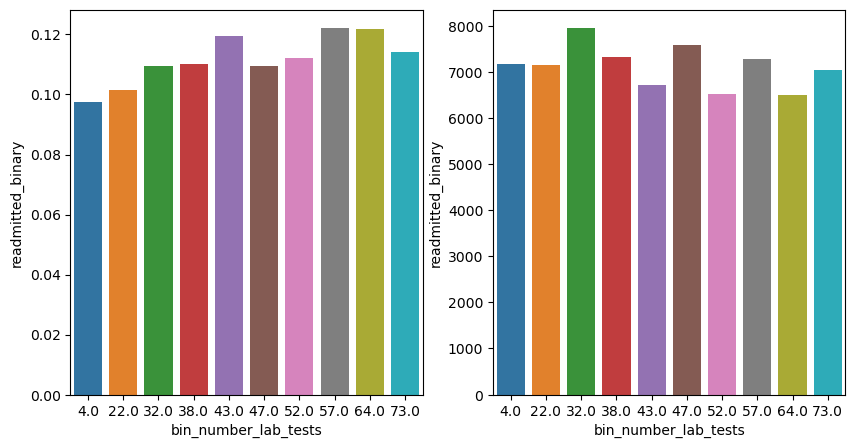

In [41]:
i = 'bin_number_lab_tests'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['readmitted_binary'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='readmitted_binary', data=counts, ax=axes[1])

<Axes: xlabel='non_lab_procedures', ylabel='readmitted_binary'>

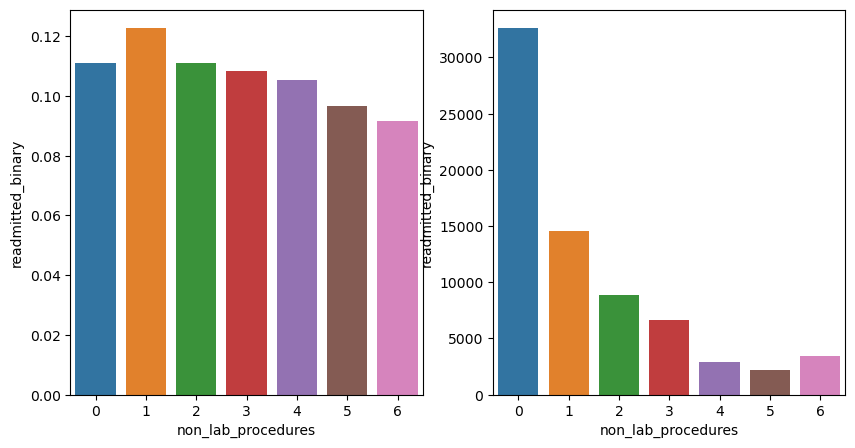

In [42]:
i = 'non_lab_procedures'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['readmitted_binary'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='readmitted_binary', data=counts, ax=axes[1])

### Train set below

In [4]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')

In [5]:
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 'total_visits', 'max_visits_of_

In [6]:
train_data = df_train.set_index('encounter_id')[[
       'gender', 
       'age', 
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'number_lab_tests',
       'non_lab_procedures', 
       'number_diagnoses',
       # 'change_in_meds_during_hospitalization', 
       'readmitted_binary', 
#        'has_weight', 
    
#        'payer_code_CM', 'payer_code_CP', 'payer_code_HM',
#        'payer_code_MC', 'payer_code_MD', 'payer_code_No provider',
#        'payer_code_OG', 'payer_code_Other provider', 'payer_code_SP',
#        'payer_code_UN', 
    
#        'race_Asian', 'race_Caucasian', 'race_Hispanic',
#        'race_Other', 'race_nan', 
    
       'total_visits', 'max_visits_of_one_type',
    
#        'admission_type_Emergency', 'admission_type_Other type',
#        'admission_type_Urgent', 'admission_type_nan',
    
       # 'discharged_home_hospice', 'expired', 'transferred_rehub',
       # 'transferred_another_institution', 'transferred_psychiatric_hospital',
    
       # 'medication_binary', 
#        'rosiglitazone', 'glipizide', 'repaglinide',
#        'pioglitazone', 'glimepiride', 'insulin', 'metformin', 'glyburide',
    
       # 'diabetes_diagnosis_4_digits_250', 
       # 'diabetes_diagnosis_4_digits_250.0',
       # 'diabetes_diagnosis_4_digits_250.1',
       # 'diabetes_diagnosis_4_digits_250.2',
       # 'diabetes_diagnosis_4_digits_250.3',
       # 'diabetes_diagnosis_4_digits_250.4',
       # 'diabetes_diagnosis_4_digits_250.5',
       # 'diabetes_diagnosis_4_digits_250.6',
       # 'diabetes_diagnosis_4_digits_250.7',
       # 'diabetes_diagnosis_4_digits_250.8',
       # 'diabetes_diagnosis_4_digits_250.9', 
#        'diabetes_type_I - uncontrolled',
#        'diabetes_type_II - controlled', 
#        'diabetes_type_II - uncontrolled',
#        'diabetes_type_nan',
    'average_pulse_bpm',
       'length_of_stay_in_hospital',
       'number_of_medications', 
       # 'num_visits_before', 
       # 'readmitted_before',
       # 'visited_before'
]]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 533253 to 459757
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              71236 non-null  float64
 1   age                                 71236 non-null  float64
 2   outpatient_visits_in_previous_year  71236 non-null  int64  
 3   emergency_visits_in_previous_year   71236 non-null  int64  
 4   inpatient_visits_in_previous_year   71236 non-null  int64  
 5   number_lab_tests                    71236 non-null  float64
 6   non_lab_procedures                  71236 non-null  int64  
 7   number_diagnoses                    71236 non-null  int64  
 8   readmitted_binary                   71236 non-null  int64  
 9   total_visits                        71236 non-null  int64  
 10  max_visits_of_one_type              71236 non-null  int64  
 11  average_pulse_bpm                  

In [8]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


In [9]:
def scaler(fit_data, transform_data, features_for_scaling):
    scaler = MinMaxScaler()
    scaler.fit(fit_data[features_for_scaling])
    scaled_df = scaler.transform(transform_data[features_for_scaling])
    scaled_df = np.concatenate((transform_data[transform_data.columns.difference(features_for_scaling)],
                    np.array(scaled_df)), axis=1)
    scaled_df = pd.DataFrame(scaled_df, columns = transform_data.columns)
    return scaled_df

Cross-validation:
1. Define train and validation with stratification by target
2. Upsample and undersample train data to balance classes
3. Train model, get metric on test
4. Switch to next datagroup
5. Calculate the average score on val
6. Reset hyperparameters and models

In [41]:
#add scaler function and reuse it inside cross val and then predict

def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     scaling = False,
                     features_for_scaling = [],
                     upsample =True, 
                     upsample_size = 1/2,
                     add_noise = False,
                     cv=5,
                     ):
    random_state = 42
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)

    #to keep proportion of original data in validation set
    majority_class = data[data[target] == 0]
    minority_class = data[data[target] == 1]
    val_majority_index = np.array_split(np.array(majority_class.index), cv)
    val_minority_index = np.array_split(np.array(minority_class.index), cv)
    f1 = []
    for i in tqdm(range(cv)):
        val_index = np.concatenate((val_majority_index[i], val_minority_index[i]))
        train_index = list(data[np.isin(data.index, val_index, invert=True)].index)
        train = data.loc[train_index]
        if upsample == True:
            majority_class = train[train[target] == 0]
            minority_class = train[train[target] == 1]
            minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*upsample_size), 
                                          random_state = random_state)
            balanced_data = pd.concat([majority_class, minority_upsampled])
            if add_noise == True:
                balanced_data['age'] = balanced_data['age'] + np.random.randint(-1, 1, balanced_data.shape[0])*10
#                 balanced_data['number_of_medications'] = balanced_data['number_of_medications'] + np.random.randint(-2, 2, balanced_data.shape[0])
                
        else:
            balanced_data = train
        X_train = balanced_data.drop(target, axis=1) 
        y_train = balanced_data[target]
        
        X_val = data.loc[val_index].drop(target, axis=1) 
        if scaling == True:
            X_val = scaler(X_train, X_val, features_for_scaling)
            X_train = scaler(X_train, X_train, features_for_scaling)
        y_val = data.loc[val_index][target]

        # print(X_train.shape, X_val.shape)

        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        f1.append([f1_score(y_pred_train, y_train), f1_score(y_pred_val, y_val)])
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model, np.array(f1).mean(axis = 0), f1]

    

In [40]:
#LogReg
from sklearn.linear_model import  LogisticRegression


target = 'readmitted_binary'
data = scaled_df_train_for_transform
cv= 5
params = {
    'penalty': ['l1', 'l2'],         # Regularization type
    'C': [ 0.01, 0.1, 1],  # Inverse of regularization strength
}
features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']
result = []
for i in range(5):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                                   target, 
                                   LogisticRegression(solver='liblinear', class_weight = 'balanced' ), 
                                   random_params, 
                                   features_for_scaling = features_for_scaling,
                                   scaling = True,
                                   cv=3, 
                                   upsample = False,
                                  upsample_size = 1,
                                  add_noise = True))

 33%|███████████████                              | 1/3 [00:00<00:00,  5.56it/s]

(71236, 13) (23746, 13)
(71236, 13) (23745, 13)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


(71236, 13) (23745, 13)
LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
F1 train: 0.738, F1_val: 0.738


  0%|                                                     | 0/3 [00:00<?, ?it/s]

(71236, 13) (23746, 13)


 33%|███████████████                              | 1/3 [00:15<00:30, 15.35s/it]

(71236, 13) (23745, 13)


 67%|██████████████████████████████               | 2/3 [00:30<00:15, 15.01s/it]

(71236, 13) (23745, 13)


100%|█████████████████████████████████████████████| 3/3 [00:45<00:00, 15.01s/it]


LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
F1 train: 0.738, F1_val: 0.738


  0%|                                                     | 0/3 [00:00<?, ?it/s]

(71236, 13) (23746, 13)


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  4.26it/s]

(71236, 13) (23745, 13)
(71236, 13) (23745, 13)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
F1 train: 0.738, F1_val: 0.738


 33%|███████████████                              | 1/3 [00:00<00:00,  6.55it/s]

(71236, 13) (23746, 13)
(71236, 13) (23745, 13)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.15it/s]


(71236, 13) (23745, 13)
LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
F1 train: 0.564, F1_val: 0.564


  0%|                                                     | 0/3 [00:00<?, ?it/s]

(71236, 13) (23746, 13)


 33%|███████████████                              | 1/3 [00:00<00:00,  5.67it/s]

(71236, 13) (23745, 13)


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  4.77it/s]

(71236, 13) (23745, 13)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]

LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')
F1 train: 0.679, F1_val: 0.679


In [12]:
#random search GB

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random

target = 'readmitted_binary'
data = train_data
cv= 5
params = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinking
    'max_depth': [3, 4, 5, 6],  # Maximum depth of individual trees
}
result = []
for i in range(2):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                                   target, 
                                   GradientBoostingClassifier(), 
                                   random_params, 
                                   cv=5, 
                                   upsample = True,
                                  upsample_size = 1,
                                  add_noise = True))

TypeError: cross_validation() missing 1 required positional argument: 'features_for_scaling'

In [ ]:
#random search SVM

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm

target = 'readmitted_binary'
data = train_data
cv= 5
params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear'],  # Kernel type
    'class_weight': ['balanced']
#     'degree': [2, 3, 4],  # Degree of the polynomial kernel
}
features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']

result = []
for i in range(3):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, target, SVC(), random_params, features_for_scaling, cv=5))
    


  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [15]:
#random search KNN

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm

target = 'readmitted_binary'
data = train_data
cv= 5
params = {
    'n_neighbors': [3, 5, 7, 9, 12, 15],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting strategy for neighbors
    'p': [1, 2],  # Power parameter for Minkowski distance (1: Manhattan, 2: Euclidean)
}
features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']
result = []
for i in range(2):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, target, KNeighborsClassifier(), random_params, features_for_scaling, cv=5))

100%|█████████████████████████████████████████████| 5/5 [01:01<00:00, 12.31s/it]


KNeighborsClassifier(n_neighbors=15)
F1 train: 0.610, F1_val: 0.125


100%|█████████████████████████████████████████████| 5/5 [01:08<00:00, 13.73s/it]

KNeighborsClassifier(n_neighbors=9, p=1)
F1 train: 0.718, F1_val: 0.204


In [42]:
#random search RandomForest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm

target = 'readmitted_binary'
data = train_data
cv= 5
params = {
    'n_estimators': np.random.randint(20, 200, 10),
    'max_depth': np.random.randint(5, 30, 10),
    'min_samples_split': np.random.randint(2, 20, 10),
    'min_samples_leaf': np.random.randint(1, 20, 10),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']
result = []
for i in range(5):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                                   target, 
                                   RandomForestClassifier(), 
                                   random_params, 
                                   features_for_scaling,
                                   cv=5, 
                                   upsample = False,
#                                    upsample_size = 1,
#                                    add_noise = True
                                  )
                 )


100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=23, min_samples_leaf=18, min_samples_split=15,
                       n_estimators=48)
F1 train: 0.490, F1_val: 0.236


100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.89s/it]


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=21, min_samples_leaf=8,
                       min_samples_split=19, n_estimators=56)
F1 train: 0.767, F1_val: 0.212


100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=23, min_samples_leaf=18,
                       min_samples_split=19, n_estimators=45)
F1 train: 0.592, F1_val: 0.240


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=9, min_samples_leaf=6,
                       min_samples_split=19, n_estimators=39)
F1 train: 0.308, F1_val: 0.250


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=21, min_samples_leaf=18,
                       min_samples_split=19, n_estimators=97)
F1 train: 0.594, F1_val: 0.240


In [55]:
#random search RandomForest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm

target = 'readmitted_binary'
data = train_data
cv= 5
params = {
    'n_estimators': np.random.randint(120, 200, 5),
    'max_depth': np.random.randint(10, 20, 3),
    'min_samples_split': np.random.randint(2, 20, 3),
    'min_samples_leaf': np.random.randint(1, 20, 3),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
result = []
for i in range(5):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                                   target, 
                                   RandomForestClassifier(), 
                                   random_params, 
                                   cv=5, 
                                   upsample = False,
                                   upsample_size = 1,
                                   add_noise = True))

100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.51s/it]


RandomForestClassifier(class_weight='balanced', max_depth=19,
                       min_samples_leaf=6, min_samples_split=8,
                       n_estimators=136)
F1 train: 0.576, F1_val: 0.284


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.61s/it]


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=146)
F1 train: 0.362, F1_val: 0.298


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.57s/it]


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=19, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=136)
F1 train: 0.563, F1_val: 0.284


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       min_samples_leaf=6, min_samples_split=8,
                       n_estimators=136)
F1 train: 0.549, F1_val: 0.288


100%|█████████████████████████████████████████████| 5/5 [00:25<00:00,  5.10s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=161)
F1 train: 0.455, F1_val: 0.300


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm

target = 'readmitted_binary'
data = train_data
cv= 5
params = {
    'n_estimators': np.random.randint(150, 200, 5),
    'max_depth': np.random.randint(10, 20, 3),
    'min_samples_split': np.random.randint(2, 10, 3),
    'min_samples_leaf': np.random.randint(7, 15, 3),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
result = []
for i in range(5):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                                   target, 
                                   RandomForestClassifier(), 
                                   random_params, 
                                   cv=5, 
                                   upsample = True,
                                   upsample_size = 1/2,
                                   add_noise = False
                                  ))

100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=15, min_samples_leaf=12,
                       min_samples_split=4, n_estimators=154)
F1 train: 0.707, F1_val: 0.298


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.12s/it]


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=12, min_samples_split=4,
                       n_estimators=177)
F1 train: 0.678, F1_val: 0.298


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.56s/it]


RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=11,
                       min_samples_leaf=12, min_samples_split=5,
                       n_estimators=155)
F1 train: 0.607, F1_val: 0.296


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.04s/it]


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=11, min_samples_split=4,
                       n_estimators=154)
F1 train: 0.688, F1_val: 0.298


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.55s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, min_samples_leaf=11, min_samples_split=5,
                       n_estimators=177)
F1 train: 0.597, F1_val: 0.296


In [80]:
from sklearn.utils import resample

X = train_data.drop('readmitted_binary', axis=1) 
y = train_data['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
print(X_train.shape)

train_new = pd.concat([X_train, y_train], axis = 1)
majority_class = train_new[train_new['readmitted_binary'] == 0]
minority_class = train_new[train_new['readmitted_binary'] == 1]

minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)/2))
balanced_data = pd.concat([majority_class, minority_upsampled])

X_train = balanced_data.drop('readmitted_binary', axis=1) 
y_train = balanced_data['readmitted_binary']
X_train.shape

(47373, 27)


(63123, 27)

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63123 entries, 28393 to 8834
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              63123 non-null  float64
 1   age                                 63123 non-null  float64
 2   weight                              63123 non-null  int64  
 3   outpatient_visits_in_previous_year  63123 non-null  int64  
 4   emergency_visits_in_previous_year   63123 non-null  int64  
 5   inpatient_visits_in_previous_year   63123 non-null  int64  
 6   number_of_medications               63123 non-null  int64  
 7   visited_before                      63123 non-null  int64  
 8   readmitted_before                   63123 non-null  float64
 9   race_Caucasian                      63123 non-null  float64
 10  discharged_home_hospice             63123 non-null  int64  
 11  expired                             63

In [175]:
import pandas as pd


feature_names = [i for i in X.columns]
importances = result[0][0].feature_importances_
std = np.std([tree.feature_importances_ for tree in result[0][0].estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

ValueError: Length of values (17) does not match length of index (28)

In [ ]:
# from sklearn import svm
# svm_classifier = svm.SVC()

# svm_classifier.fit(X_train, y_train)
# y_train_pred = svm_classifier.predict(X_train)
# y_test_pred = svm_classifier.predict(X_test)

# f1_train = f1_score(y_train, y_train_pred)
# f1_test = f1_score(y_test, y_test_pred)

In [ ]:
print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Testing Data: {f1_test:.2f}")

In [81]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define a range of hyperparameters to search
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(2, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, random_state=42, scoring='f1', verbose=1)

# Fit the RandomizedSearchCV object to your training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best hyperparameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

# Evaluate the model on the test data
best_rf = random_search.best_estimator_
test_f1 = best_rf.score(X_test, y_test)

print("Test F1 score using best model:", test_f1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 12, 'min_samples_split': 3, 'n_estimators': 199}
Best F1 score: 0.49790605210221506
Test F1 score using best model: 0.8559818745998128


F1 - 0.58, recall - 0.17
F1 Score on Testing Data: 0.21


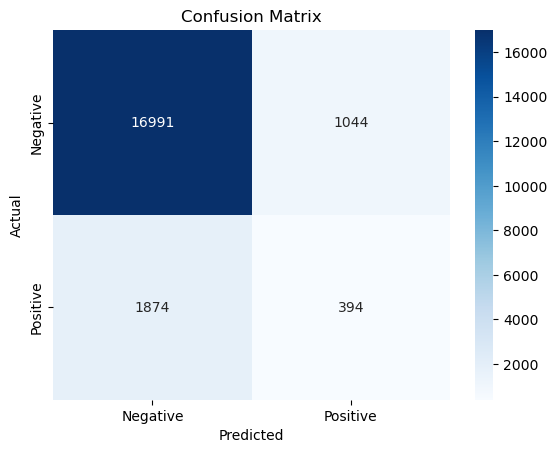

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

params = {'bootstrap': False, 
       'criterion': 'gini', 
       'max_depth': 19, 
       'min_samples_leaf': 12, 
       'min_samples_split': 3, 
       'n_estimators': 199}
rf_classifier = RandomForestClassifier(**params)
rf_classifier.fit(X_train, y_train)
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print("F1 - {:.2f}, recall - {:.2f}".format(f1_train, recall_score(y_test, y_test_pred)))
print(f"F1 Score on Testing Data: {f1_test:.2f}")

labels = ['Negative', 'Positive']
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [86]:
df_test

,encounter_id,patient_id,race,gender,age,weight,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,...,insulin,metformin,troglitazone,metformin-pioglitazone,rosiglitazone,acetohexamide,diabetes_diagnosis,num_visits_before,readmitted_before,visited_before
0,499502,103232799,Caucasian,0.0,8.0,0,0,0,0,Emergency,...,0,1,0,0,0,0,250,1.0,0.0,1
1,447319,93395304,Caucasian,0.0,2.0,0,0,0,1,Emergency,...,0,0,0,0,0,0,250.13,1.0,0.0,1
2,309126,6281586,AfricanAmerican,0.0,3.0,0,0,0,0,Emergency,...,1,0,0,0,0,0,250.6,0.0,0.0,0
3,181183,67381308,Caucasian,0.0,5.0,0,0,0,0,Not Available,...,1,1,0,0,0,0,,0.0,0.0,0
4,359339,71670204,Caucasian,0.0,6.0,0,0,0,0,Emergency,...,0,1,0,0,0,0,,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,451150,85707450,Caucasian,0.0,7.0,0,0,0,0,Emergency,...,0,0,0,0,0,0,,0.0,0.0,0
30526,549298,328887,Caucasian,0.0,6.0,0,0,0,4,Emergency,...,1,0,0,0,0,0,250.83,4.0,0.0,1
30527,327586,21915459,Caucasian,1.0,8.0,0,0,0,0,Emergency,...,1,0,0,0,0,0,250,0.0,0.0,0
30528,351214,17823546,Caucasian,0.0,NaN,0,0,0,0,Urgent,...,1,0,0,0,0,0,,0.0,0.0,0


In [ ]:
rf_classifier.predict()

In [133]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(random_state=1, max_iter=200, hidden_layer_sizes=(30,30)).fit(X_train, y_train)
mlp_classifier.fit(X_train, y_train)
y_train_pred = mlp_classifier.predict(X_train)
y_test_pred = mlp_classifier.predict(X_test)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Testing Data: {f1_test:.2f}")

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 Score on Training Data: 0.06
F1 Score on Testing Data: 0.03


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Predicitions

In [37]:
train_data

,gender,age,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,number_lab_tests,non_lab_procedures,number_diagnoses,readmitted_binary,total_visits,max_visits_of_one_type,average_pulse_bpm,length_of_stay_in_hospital,number_of_medications
encounter_id,,,,,,,,,,,,,,
533253,1.0,75.0,0,0,2,48.0,0,8,0,2,2,127,2,20.0
426224,0.0,55.0,0,0,0,71.0,0,9,0,0,0,128,14,25.0
634063,1.0,65.0,0,0,1,60.0,1,6,0,1,1,94,6,22.0
890610,0.0,65.0,0,0,1,48.0,2,5,0,1,1,81,6,9.0
654194,1.0,75.0,1,0,0,47.0,1,9,0,1,1,126,6,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660160,1.0,85.0,0,1,0,51.0,1,9,0,1,1,90,7,18.0
826429,1.0,75.0,0,0,0,20.0,0,6,0,0,0,98,9,9.0
332030,1.0,65.0,0,2,2,25.0,0,9,1,4,2,137,5,24.0


In [45]:
train = train_data
majority_class = train[train[target] == 0]
minority_class = train[train[target] == 1]
minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)), 
                                  random_state = random_state)
balanced_data = pd.concat([majority_class, minority_upsampled])
balanced_data['age'] = balanced_data['age'] + np.random.randint(-1, 1, balanced_data.shape[0])
balanced_data['number_of_medications'] = balanced_data['number_of_medications'] + np.random.randint(-2, 2, balanced_data.shape[0])

X_train = balanced_data.drop(target, axis=1) 
y_train = balanced_data[target]

In [46]:
model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=161)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
f1_score(y_pred_train, y_train)

0.6788408750965664

In [56]:
X_final = df_test.set_index('encounter_id')[['gender', 
                       'age', 
                       'has_weight',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'total_visits',
       'max_visits_of_one_type',  
       'number_of_medications',
       'bin_number_of_medications',  
       'bin_length_of_stay_in_hospital',                                        
       'num_visits_before',
       'visited_before',
       'readmitted_before',
       'race_Caucasian', 
       'discharged_home_hospice',
       'expired', 
       'transferred_rehub', 
       'transferred_another_institution',
       'transferred_psychiatric_hospital', 
       'length_of_stay_in_hospital',
       'change_in_meds_during_hospitalization',                               
       'medication_binary',
       'metformin', 'glyburide', 'rosiglitazone',
       'insulin', 'glimepiride', 'pioglitazone', 'repaglinide', 'glipizide']]
df_test['readmitted_binary'] = model.predict(X_final)
df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v2.csv', index = False)

                              Feature  Importance
5                    number_lab_tests    0.099905
62                  num_visits_before    0.073741
61          bin_number_of_medications    0.058570
64                     visited_before    0.057339
1                                 age    0.054344
..                                ...         ...
55  diabetes_diagnosis_4_digits_250.9    0.000302
49  diabetes_diagnosis_4_digits_250.3    0.000002
35   transferred_psychiatric_hospital    0.000000
33                  transferred_rehub    0.000000
28          admission_type_Other type    0.000000

[65 rows x 2 columns]


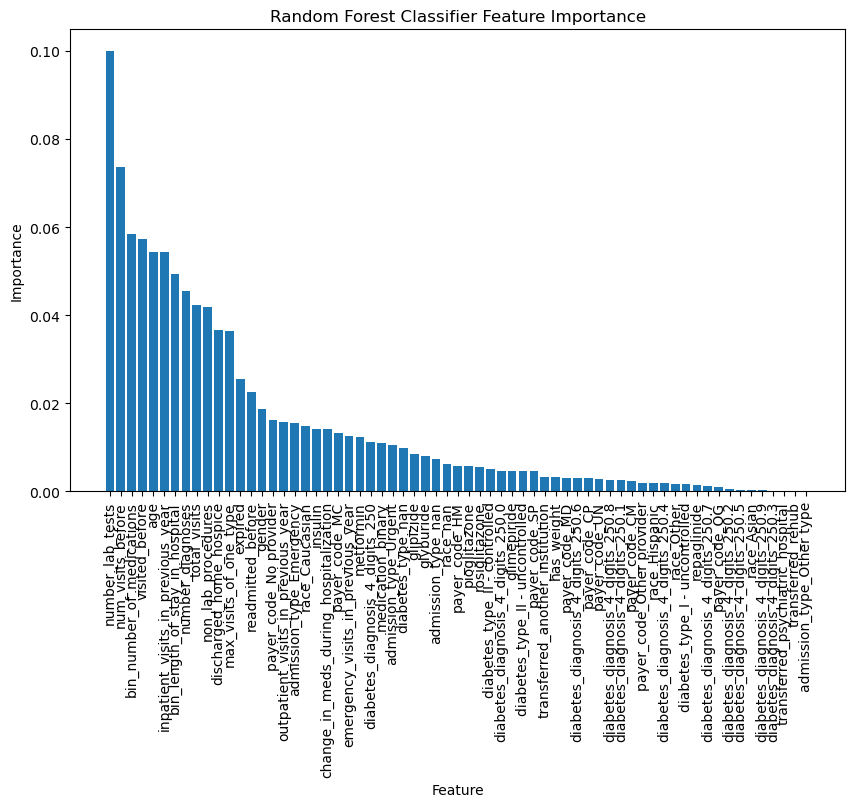

In [61]:
# Get feature importances
feature_importances = model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print or visualize the sorted feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Classifier Feature Importance")
plt.xticks(rotation=90)
plt.show()


In [38]:
train_data.columns

Index(['gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'number_lab_tests',
       'non_lab_procedures', 'number_diagnoses', 'readmitted_binary',
       'total_visits', 'max_visits_of_one_type', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_of_medications'],
      dtype='object')

In [17]:
### Submit_v4
df_test = pd.read_csv('Data/df_test_preprocessed.csv')
features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']

train = train_data
X_train = train_data.drop(target, axis=1) 
X_train = scaler(X_train,X_train, features_for_scaling)
y_train = train_data[target]

model = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
f1_score(y_pred_train, y_train)

X_final = df_test.set_index('encounter_id')[['gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'number_lab_tests',
       'non_lab_procedures', 'number_diagnoses', 
       'total_visits', 'max_visits_of_one_type', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_of_medications']]
X_final = scaler(X_train, X_final, features_for_scaling)


df_test['readmitted_binary'] = model.predict(X_final)
df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
# df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v4.csv', index = False)

In [58]:
### Submit_v3

train = train_data
X_train = train_data.drop(target, axis=1) 
y_train = train_data[target]

model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=161)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
f1_score(y_pred_train, y_train)

X_final = df_test.set_index('encounter_id')[['gender', 'age', 
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'number_lab_tests',
       'non_lab_procedures', 
       'number_diagnoses',
       'change_in_meds_during_hospitalization', 
       'has_weight', 'payer_code_CM', 'payer_code_CP', 'payer_code_HM',
       'payer_code_MC', 'payer_code_MD', 'payer_code_No provider',
       'payer_code_OG', 'payer_code_Other provider', 'payer_code_SP',
       'payer_code_UN', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'total_visits', 'max_visits_of_one_type',
       'admission_type_Emergency', 'admission_type_Other type',
       'admission_type_Urgent', 'admission_type_nan',
       'discharged_home_hospice', 'expired', 'transferred_rehub',
       'transferred_another_institution', 'transferred_psychiatric_hospital',
       'medication_binary', 'rosiglitazone', 'glipizide', 'repaglinide',
       'pioglitazone', 'glimepiride', 'insulin', 'metformin', 'glyburide',
       'diabetes_diagnosis_4_digits_250', 'diabetes_diagnosis_4_digits_250.0',
       'diabetes_diagnosis_4_digits_250.1',
       'diabetes_diagnosis_4_digits_250.2',
       'diabetes_diagnosis_4_digits_250.3',
       'diabetes_diagnosis_4_digits_250.4',
       'diabetes_diagnosis_4_digits_250.5',
       'diabetes_diagnosis_4_digits_250.6',
       'diabetes_diagnosis_4_digits_250.7',
       'diabetes_diagnosis_4_digits_250.8',
       'diabetes_diagnosis_4_digits_250.9', 
       'diabetes_type_I - uncontrolled',
       'diabetes_type_II - controlled', 
       'diabetes_type_II - uncontrolled',
       'diabetes_type_nan',
       'bin_length_of_stay_in_hospital',
       'bin_number_of_medications', 'num_visits_before', 'readmitted_before',
       'visited_before']]
df_test['readmitted_binary'] = model.predict(X_final)
df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v3.csv', index = False)

In [ ]:
### Submit_v1

train = train_data
majority_class = train[train[target] == 0]
minority_class = train[train[target] == 1]
minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)), 
                                  random_state = random_state)
balanced_data = pd.concat([majority_class, minority_upsampled])
balanced_data['age'] = balanced_data['age'] + np.random.randint(-1, 1, balanced_data.shape[0])
balanced_data['number_of_medications'] = balanced_data['number_of_medications'] + np.random.randint(-2, 2, balanced_data.shape[0])

X_train = balanced_data.drop(target, axis=1) 
y_train = balanced_data[target]

model = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=13,
                       min_samples_leaf=13, min_samples_split=9,
                       n_estimators=44)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
f1_score(y_pred_train, y_train)
df_test.set_index('encounter_id')[['gender', 
                       'age', 
                       'has_weight',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'number_of_medications',                                     
       'bin_number_of_medications',             
       'num_visits_before',
       'visited_before',
       'readmitted_before', 
       'race_Caucasian', 
       'discharged_home_hospice',
       'expired', 
       'transferred_rehub', 
       'transferred_another_institution',
       'transferred_psychiatric_hospital', 
       'length_of_stay_in_hospital',
       'change_in_meds_during_hospitalization',                               
       'medication_binary']].fillna(0)

In [ ]:
#Submit V2

train = train_data
majority_class = train[train[target] == 0]
minority_class = train[train[target] == 1]
minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)), 
                                  random_state = random_state)
balanced_data = pd.concat([majority_class, minority_upsampled])
balanced_data['age'] = balanced_data['age'] + np.random.randint(-1, 1, balanced_data.shape[0])
balanced_data['number_of_medications'] = balanced_data['number_of_medications'] + np.random.randint(-2, 2, balanced_data.shape[0])

X_train = balanced_data.drop(target, axis=1) 
y_train = balanced_data[target]


model = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=11,
                       min_samples_leaf=10, min_samples_split=17,
                       n_estimators=154)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
f1_score(y_pred_train, y_train)

X_final = df_test.set_index('encounter_id')[['gender', 
                       'age', 
                       'has_weight',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       'total_visits',
       'max_visits_of_one_type',  
       'number_of_medications',
       'bin_number_of_medications',  
       'bin_length_of_stay_in_hospital',                                        
       'num_visits_before',
       'visited_before',
       'readmitted_before',
       'race_Caucasian', 
       'discharged_home_hospice',
       'expired', 
       'transferred_rehub', 
       'transferred_another_institution',
       'transferred_psychiatric_hospital', 
       'length_of_stay_in_hospital',
       'change_in_meds_during_hospitalization',                               
       'medication_binary',
       'metformin', 'glyburide', 'rosiglitazone',
       'insulin', 'glimepiride', 'pioglitazone', 'repaglinide', 'glipizide']]
df_test['readmitted_binary'] = model.predict(X_final)
df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v2.csv', index = False)